# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

# Exercise 3.1

In [4]:
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [5]:
movies = data.map(itemgetter("movieId")).distinct()
nbMovies = movies.count()
#map to remember which movies is in which row in the matrix
movies_index = dict(movies.zipWithIndex().collect())
tags = data.map(itemgetter("tagId")).distinct()
nbTags = tags.count()

In [6]:
#map of the form [(movieId,tagId),relevance]
score_map = data.map(itemgetter("movieId", "tagId", "relevance")).map(lambda x : ((x[0],x[1]),x[2]))

In [7]:
scores = score_map.collect()

In [8]:
#filling the matrix with datas
matrix = np.ndarray(shape=(nbMovies,nbTags))
for score in scores:
    movieID = score[0][0]
    tagID = score[0][1]
    matrix[(movies_index[movieID],tagID -1 )] = score[1]

In [9]:
#computing variances for all columns
var_array = np.var(matrix,axis = 0)
total_variance = sum(var_array)
sorted_var_array = np.sort(var_array)

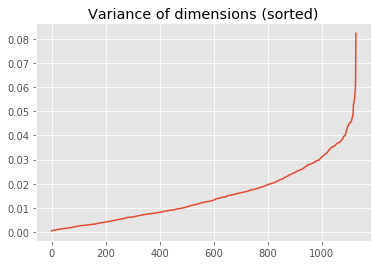

In [13]:
plt.plot(sorted_var_array)
plt.title("Variance of dimensions (sorted)")
plt.show()

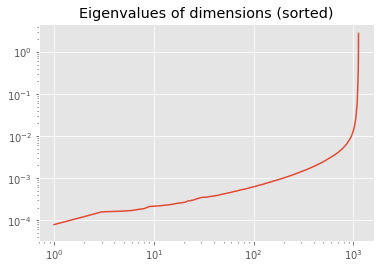

In [14]:
centered_matrix = matrix - np.mean(matrix,axis = 0)
covariance_matrix = np.cov(centered_matrix, rowvar=False, bias = True)
values,vectors = np.linalg.eigh(covariance_matrix)
plt.plot(values)
plt.yscale('log')
plt.xscale('log')
plt.title("Eigenvalues of dimensions (sorted)")
plt.show()

In [12]:
variance_PCS = 0;
index = len(vectors)
while index > 0 and variance_PCS < 2 / 3:
    index -= 1
    PC = np.matmul(centered_matrix,vectors[:,index])
    partial_var = np.var(PC) / total_variance
    variance_PCS += partial_var
    print("Principal component " + str(len(vectors) - index) + " captures " + str(partial_var * 100) +"% of the total variance")
    
print(str(len(vectors)-index) + " components capture " + str(variance_PCS * 100) + "% of the total variance")

Principal component 1 captures 16.0998401824% of the total variance
Principal component 2 captures 7.14231474524% of the total variance
Principal component 3 captures 5.82421785317% of the total variance
Principal component 4 captures 3.87194266108% of the total variance
Principal component 5 captures 3.42494118574% of the total variance
Principal component 6 captures 2.7735405351% of the total variance
Principal component 7 captures 2.69809092675% of the total variance
Principal component 8 captures 2.3226015567% of the total variance
Principal component 9 captures 1.99696401373% of the total variance
Principal component 10 captures 1.68924810457% of the total variance
Principal component 11 captures 1.52504419883% of the total variance
Principal component 12 captures 1.36710573857% of the total variance
Principal component 13 captures 1.30008923777% of the total variance
Principal component 14 captures 1.21490078948% of the total variance
Principal component 15 captures 1.12693104698

As seen above, 37 components capture 66.98% of the total variance

For dimensionnality reduction, it means that we can recompute the coordinates of the movies according to the principal components and that we don't need all the dimensions to have a good grasp on the data variance

# Exercise 3.2


In [15]:
def print_max_min_PC(PC):
    PC_index = sorted([(x,index[0]) for index, x in np.ndenumerate(PC)])
    #remember : tagId n is at index n-1
    tag_minimum = [pair[1] + 1 for pair in PC_index[:10]]
    tag_maximum = [pair[1] + 1 for pair in PC_index[-10:]][::-1]
    print("Maximum: ")
    for tag in tag_maximum:
        print(tag2name[tag])

    print()    
    print("Minimum")
    for tag in tag_minimum:
        print(tag2name[tag])
    return tag_minimum, tag_maximum

PC = [0] * 5

### First principal component

In [16]:
PC[0] = vectors[:,-1]
mini_PC1, maxi_PC1 = print_max_min_PC(PC[0])

Maximum: 
talky
social commentary
criterion
imdb top 250
great acting
drama
oscar (best directing)
bleak
dramatic
cinematography

Minimum
predictable
so bad it's funny
bad plot
silly
silly fun
horrible
franchise
lame
big budget
comedy


**Concept** : "Great movie" VS third-rate film

### Second principal component

In [17]:
PC[1] = vectors[:,-2]
mini_PC2, maxi_PC2 = print_max_min_PC(PC[1])

Maximum: 
intimate
relationships
criterion
melancholic
loneliness
golden palm
meditative
art house
melancholy
sexual

Minimum
action
special effects
big budget
chase
fast paced
suspense
good action
plot
pg-13
action packed


**Concept** : Romantic vs Action

### Third principal component

In [18]:
PC[2] = vectors[:,-3]
mini_PC3, maxi_PC3 = print_max_min_PC(PC[2])

Maximum: 
feel-good
sentimental
love story
heartwarming
touching
romantic
sweet
courage
girlie movie
feel good movie

Minimum
horror
weird
creepy
splatter
stylish
cult classic
disturbing
violence
cult film
dark


**Concept** : "Girly" vs Horror

### Fourth principal component

In [19]:
PC[3] = vectors[:,-4]
mini_PC4, maxi_PC4 = print_max_min_PC(PC[3])

Maximum: 
visual
visually stunning
imagination
sci-fi
scifi
visually appealing
science fiction
sci fi
special effects
beautifully filmed

Minimum
corruption
crime
murder
police investigation
thriller
suspense
violence
police corruption
gangsters
manipulation


**Concept** : CGI vs thriller

### Fifth principal component

In [20]:
PC[4] = vectors[:,-5]
mini_PC5, maxi_PC5 = print_max_min_PC(PC[4])

Maximum: 
thriller
conspiracy
secrets
suspenseful
tense
mystery
suspense
investigation
murder mystery
betrayal

Minimum
comedy
funny
hilarious
goofy
humorous
humor
very funny
cult classic
quotable
funny as hell


**Concept** : Suspense vs comedy

In [21]:
tag2score = dict()
for i in range(len(PC[0])):
    values = []
    for j in range(len(PC)):
        values.append(PC[j][i])
    tag2score[tag2name[i+1]] = values
    
with open("tag2score.pickle", "wb") as f:
    pickle.dump(tag2score, f)

# Exercise 3.3

In [22]:
with open("selected-movies.pickle", "rb") as f:
    movies_pickle = pickle.load(f, encoding="utf-8")

In [23]:
coord_list = []
for movie in movies_pickle:
    coord1 = np.dot(centered_matrix[movies_index[movie[0]]],PC[0])
    coord2 = np.dot(centered_matrix[movies_index[movie[0]]],PC[1])
    coord_list.append((coord1,coord2))

In [24]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
from matplotlib.colors import rgb2hex 
output_notebook()

Loading BokehJS ...

In [25]:
def val2color(val):
    return rgb2hex((1- val,val,0))

source = ColumnDataSource(
    data={
        "x": [x[0] for x in coord_list],
        "y": [x[1] for x in coord_list],
        "name": [x[1] for x in movies_pickle],
        "score": [x[2] for x in movies_pickle],
        "color": [val2color(x[2]) for x in movies_pickle],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("Score", "@score"),
    ])

tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20,color="color", alpha=0.5)
show(p, notebook_handle=True)

Films like Terminator, Star Wars or Edge of Tomorrow are actions movie hence on the lowest coordinates on the y-axis

Fightclub is a good movie, and therefore on the right side of the graph

The concept of the first principal component is pretty much good vs bad movies, hence we get better Rotten Tomatoes score on the right side of the graph